In [1]:
import pandas as pd
data = pd.read_csv("time_series_30min_singleindex.csv")

data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'])
data['utc_timestamp'] = data['utc_timestamp'].dt.date
data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'])
# data['utc_timestamp'] = pd.to_datetime(df.Date) + pd.offsets.MonthBegin(0)

data = data.drop_duplicates(subset='utc_timestamp', keep='first')


data.set_index('utc_timestamp', inplace=True)
# data.index = data.index.floor('1M')
data.head()


,cet_cest_timestamp,CY_load_actual_entsoe_transparency,CY_load_forecast_entsoe_transparency,CY_wind_onshore_generation_actual,FR_load_actual_tso,FR_load_forecast_tso,FR_solar_generation_actual,FR_wind_onshore_generation_actual,GB_EAW_load_actual_tso,GB_GBN_load_actual_entsoe_transparency,...,GB_UKM_wind_onshore_capacity,GB_UKM_wind_onshore_generation_actual,GB_UKM_wind_onshore_profile,IE_load_actual_entsoe_transparency,IE_load_forecast_entsoe_transparency,IE_wind_onshore_generation_actual,IE_sem_load_actual_entsoe_transparency,IE_sem_load_forecast_entsoe_transparency,IE_sem_price_day_ahead,IE_sem_wind_onshore_generation_actual
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2005-03-31,2005-04-01 01:30:00+0200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28871.0,NaN,...,1371.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-04-01,2005-04-01 02:00:00+0200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30340.0,NaN,...,1371.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-04-02,2005-04-02 02:00:00+0200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28910.0,NaN,...,1371.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-04-03,2005-04-03 02:00:00+0200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27491.0,NaN,...,1371.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-04-04,2005-04-04 02:00:00+0200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27054.0,NaN,...,1371.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
data = data['GB_EAW_load_actual_tso']
# data = data.round('MS')
data = data[: int((len(data)*35)/100) ]
data = data.astype('float64')
data.head()

utc_timestamp
2005-03-31    28871.0
2005-04-01    30340.0
2005-04-02    28910.0
2005-04-03    27491.0
2005-04-04    27054.0
Name: GB_EAW_load_actual_tso, dtype: float64

In [3]:
data.columns = ['Energy Production']

train = data[:int((70*len(data)/100))]
valid = data[int((70*len(data)/100)):]

In [4]:
len(data)

1800

In [5]:
import cufflinks as cf
import plotly.offline
from  plotly.offline import plot_mpl
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

data.iplot(title="power")

In [6]:
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data, lags=50)
pyplot.show()

<Figure size 640x480 with 1 Axes>

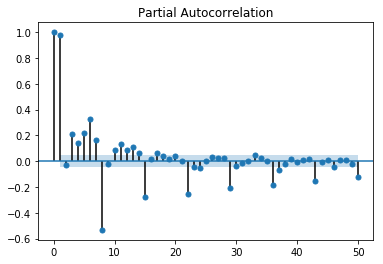

In [7]:

plot_pacf(data, lags=50)
pyplot.show()

In [9]:
import warnings
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        # calculate out of sample error
        error = mean_squared_error(test, predictions)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    print(order, "Nan")
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))


series = data
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
# warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

(0, 0, 0) Nan
(0, 0, 1) Nan
(0, 0, 2) Nan
(0, 1, 0) Nan
(0, 1, 1) Nan
(0, 1, 2) Nan
(0, 2, 0) Nan
(0, 2, 1) Nan
(0, 2, 2) Nan
(1, 0, 0) Nan
(1, 0, 1) Nan
(1, 0, 2) Nan
(1, 1, 0) Nan
(1, 1, 1) Nan
(1, 1, 2) Nan
(1, 2, 0) Nan
(1, 2, 1) Nan
(1, 2, 2) Nan
(2, 0, 0) Nan
(2, 0, 1) Nan
(2, 0, 2) Nan
(2, 1, 0) Nan
(2, 1, 1) Nan
(2, 1, 2) Nan
(2, 2, 0) Nan
(2, 2, 1) Nan
(2, 2, 2) Nan
(4, 0, 0) Nan
(4, 0, 1) Nan


/home/cooldudeanmol/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning:

overflow encountered in exp

/home/cooldudeanmol/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning:

overflow encountered in exp

/home/cooldudeanmol/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning:

invalid value encountered in true_divide

/home/cooldudeanmol/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:608: RuntimeWarning:

overflow encountered in exp

/home/cooldudeanmol/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning:

overflow encountered in exp

/home/cooldudeanmol/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning:

invalid value encountered in true_divide



(4, 0, 2) Nan
(4, 1, 0) Nan
(4, 1, 1) Nan
(4, 1, 2) Nan
(4, 2, 0) Nan
(4, 2, 1) Nan
(4, 2, 2) Nan
(6, 0, 0) Nan
(6, 0, 1) Nan
(6, 0, 2) Nan
(6, 1, 0) Nan
(6, 1, 1) Nan
(6, 1, 2) Nan
(6, 2, 0) Nan
(6, 2, 1) Nan
(6, 2, 2) Nan
(8, 0, 0) Nan
(8, 0, 1) Nan
(8, 0, 2) Nan
(8, 1, 0) Nan
(8, 1, 1) Nan
(8, 1, 2) Nan
(8, 2, 0) Nan
(8, 2, 1) Nan
(8, 2, 2) Nan
(10, 0, 0) Nan
(10, 0, 1) Nan
(10, 0, 2) Nan
(10, 1, 0) Nan
(10, 1, 1) Nan
(10, 1, 2) Nan
(10, 2, 0) Nan
(10, 2, 1) Nan
(10, 2, 2) Nan
Best ARIMANone MSE=inf


In [ ]:
from pyramid.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
model.fit(train)

# forecast = model.predict(n_periods=len(valid))
# forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set

In [ ]:
future_forecast = model.predict(n_periods=len(valid))
future_forecast


In [ ]:
future_forecast = pd.DataFrame(future_forecast,index = valid.index,columns=['Prediction'])


In [ ]:
future_forecast = pd.DataFrame(future_forecast,index = valid.index,columns=['Prediction'])
pd.concat([valid,future_forecast],axis=1).iplot()

In [ ]:
pd.concat([data,future_forecast],axis=1).iplot()


In [ ]:
#calculate rmse
from math import sqrt
from sklearn.metrics import mean_squared_error

rms = sqrt(mean_squared_error(valid,future_forecast))
print(rms)